<a href="https://colab.research.google.com/github/KcCheng1988/Jumpstart_DL/blob/master/Vehicle_Type_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Details

Name : Cheng Kok Cheong

Contact: 8506 7164

email: kcjazzy88@gmail.com

# Project - Vehicle Type Classification

The goal of this project is to classify image of vehicle using pre-trained convolutional neural network (CNN).

The image is classified according to the type of the vehicle - bicycle, bus, car, motorcycle, truck or van.

VGG - a pre-trained CNN based on images on *ImageNet*, is used for this project.

The dataset of images was obtained from:
https://www.kaggle.com/c/vehicle 



# Preparatory codes for
- importing libraries
- setting up helper functions
- mounting dataset
- splitting into train and test set
- making and assembling data pipeline.


## Load Tensorflow and Check GPU version

In [ ]:
# Load Tensorflow version 2
%tensorflow_version 2.x

In [ ]:
# Make sure GPU is installed by selecting GPU at Edit -> Notebook Settings.
!nvidia-smi

Tue Jun 16 16:35:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Testing for GPU
- Run the cell below to test if the GPU is set up.

- If no GPU is found, go to *Runtime* and select *Change Runtime Type* to GPU.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found.')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import training, callback and other libraries

In [ ]:
%matplotlib inline
# essential training libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model, Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input

from tensorflow.keras import backend as K 

import tensorflow as tf

# essential libraries for testing
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

# callback libraries
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# other libraries
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import os, json
import pandas as pd
import numpy as np
from IPython.display import Image

In [ ]:
# check the version of tensorflow and keras
print(f"Version of imported tensorflow: {tf.__version__}")
print(f"Version of imported keras: {tf.keras.__version__}")

Version of imported tensorflow: 2.2.0
Version of imported keras: 2.3.0-tf


## Functions for testing images and observing model metrics against training epochs

In [ ]:
# function that plots training and validation loss against epochs
def plot_train(hist):
  h = hist.history
  if 'acc' in h:
    meas = 'acc'
    loc = 'lower right'
  else:
    meas = 'loss'
    loc = 'upper right'
  
  plt. plot(h[meas])
  plt.plot(h['val_' + meas])
  plt.title('model ' + meas)
  plt.ylabel(meas)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc=loc)
  

In [ ]:
# helper function to test a single image
def evaluate_img(img_path, train_model):
  print(f'============Processing Image {os.path.basename(img_path)}============')

  # show the image
  im = mpimg.imread(img_path)
  plt.imshow(im)
  plt.show()

  # load and preprocess the image
  img = image.load_img(img_path, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  print('Input image shape: ', x.shape)

  # make predictions
  preds = train_model.predict(x)[0]
  print('Predicted: ', preds)

  # find index of maximum probability
  result = np.where(preds==np.amax(preds))[0]
  if result==0:
    print("It's a bicycle.")
  elif result==1:
    print("It's a bus.")
  elif result==2:
    print("It's a car.")
  elif result==3:
    print("It's a motorcycle.")
  elif result==4:
    print("It's a truck.")
  else:
    print("It's a van.")
  

# helper function to test all images in a folder
def evaluate_all_img(img_dir, train_model):
  for root, dirs, files in os.walk(img_dir):
    for name in files:
      if '.jpg' not in name:
        continue
      filename = os.path.abspath(os.path.join(root, name))
      evaluate_img(filename, train_model)

## Set up directory to store callback information

In [1]:
!mkdir checkpoints
!ls

checkpoints  sample_data


## Download the dataset

In [ ]:
# Upload the data set
!wget -q https://www.dropbox.com/s/2spqqj673xrn0ba/vehicle_classification.zip?dl=0

In [ ]:
# unzip the data folder
!unzip -q "vehicle_classification.zip?dl=0"

In [ ]:
# remove the original zip folder
!rm "vehicle_classification.zip?dl=0"

# remove __MACOSX folder generated during unzipping
# application only for Mac
!rm -r __MACOSX

### The data folder contains images of vehicles grouped according to their types. 

In [ ]:
# View the sub-directories of the data folder
!ls 'vehicle_classification/train'

ls: cannot access 'train': No such file or directory


In [ ]:
train_path='./vehicle_classification/train'
test_path='./vehicle_classficiation/test'

## Converting raw images in sub-folders into something we can feed into tf.data

- We can use *glob* to get lists of the files in the sub-folders and then convert them into dataframes and add in vehicle types (class).
- The images are shuffled for splitting into train and validation sets later.

In [ ]:
data = []
for root, dirs, files in os.walk(train_path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

# Convert the data list to data frame
df = pd.DataFrame(data, columns=['filename', 'class_name'])

# Convert the class_name column to categorical data
df['class_name'] = df['class_name'].astype('category')
  
# Convert the category to numerical class codes
df['class'] = df['class_name'].cat.codes

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print("========================================")
print(f"A total of {len(df)} images.")
print("==========Column Types of df============")
print(df.dtypes)
print("========================================")



                                            filename  class_name  class
0  /content/drive/My Drive/Vehicle_Type_Classific...  Motorcycle      3
1  /content/drive/My Drive/Vehicle_Type_Classific...       Truck      4
2  /content/drive/My Drive/Vehicle_Type_Classific...  Motorcycle      3
3  /content/drive/My Drive/Vehicle_Type_Classific...       Truck      4
4  /content/drive/My Drive/Vehicle_Type_Classific...       Truck      4
A total of 16662 images.
==========Column Types of df============
filename        object
class_name    category
class             int8
dtype: object


In [ ]:
print("List of vehicle types available in the data set:")
df['class_name'].unique()

List of vehicle types available in the data set:


[Motorcycle, Truck, Bus, Car, Van, Bicycle]
Categories (6, object): [Motorcycle, Truck, Bus, Car, Van, Bicycle]

## Split into train and validation sets

In [ ]:
# percentage of training set
train_set_percentage = 0.9

# split into train and validation sets
df_train = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [ ]:
df.shape, df_train.shape, df_val.shape

((16662, 3), (14995, 3), (1667, 3))

## Make the pipeline for loading and resizing images
- Reads image from a file
- Decodes it into a tensor
- Resizes it to a fixed shape

In [ ]:
img_rows, img_cols = 224, 224
num_classes = 6

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized, shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

## Assembling the data pipeline using tf.data

In [ ]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(( tf.cast(df_train['filename'].values, tf.string),
                                                     tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
train_dataset

<BatchDataset shapes: ((32, 224, 224, 3), (32, 6)), types: (tf.float32, tf.float32)>

# Training codes 
- Training with VGG pre-trained model with all convolutional layers set as non-trainable
- Testing with sample images
- Finetuning by turning on some convolutional layers in the VGG network


## Download the VGG network weights

In [ ]:
# create the base pre-trained model 
# include_top=False to take away the classification layers in the pre-trained model and keep only the convolutional layer
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling=None)

In [ ]:
# view the base model
# the base model consists of a sequence of convolution-pooling blocks
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Set up our own classification layers
- Set up one dense layer
- Set dropout as 0.3 (*omitted as it greatly prolonged training time*)
- Set up softmax logit layer
- Construct the model
- Change pre-trained layers to untrainable

In [ ]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# add a fully connected layer
x = Dense(512, activation='relu')(x)

# add dropout to the layer
# x = Dropout(0.3)(x)

# add a logits (softmax()) layers for 6 classes
predictions = Dense(6, activation='softmax')(x)

In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# 'Turn off' pre-trained layers
for layer in base_model.layers:
  print(layer.name)
  layer.trainable=False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
# Check the status of the layers
for layer in model.layers:
  print(layer.name, 'Trainable: ', layer.trainable)

input_1 Trainable:  False
block1_conv1 Trainable:  False
block1_conv2 Trainable:  False
block1_pool Trainable:  False
block2_conv1 Trainable:  False
block2_conv2 Trainable:  False
block2_pool Trainable:  False
block3_conv1 Trainable:  False
block3_conv2 Trainable:  False
block3_conv3 Trainable:  False
block3_pool Trainable:  False
block4_conv1 Trainable:  False
block4_conv2 Trainable:  False
block4_conv3 Trainable:  False
block4_pool Trainable:  False
block5_conv1 Trainable:  False
block5_conv2 Trainable:  False
block5_conv3 Trainable:  False
block5_pool Trainable:  False
global_average_pooling2d Trainable:  True
dense Trainable:  True
dense_1 Trainable:  True


In [ ]:
# view the layers in the final model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Set up the optimizer and compile the model

In [ ]:
# Adam algorithm is SGD that is based on adaptive estimation of 1st and 2nd order moment.
opt = tf.keras.optimizers.Adam(lr=0.001)

In [ ]:
# compule the model (should be done after setting layers to untrainable)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

In [ ]:
# view the training and validation steps
train_steps = int(14995/batch_size)
val_steps = int(1667/batch_size)

print('training steps: ', train_steps)
print('validation steps: ', val_steps)

# set epochs
epochs = 10

training steps:  468
validation steps:  52


In [ ]:
## set model checkpoints
checkpoint = ModelCheckpoint('./checkpoints/model_best_weights.hdf5',
                             monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='auto')

## set early stopping
# patience = 2: stop when validation loss doesn't improve after 2 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


## train the model with validation
history = model.fit(train_dataset,
                    steps_per_epoch = train_steps,
                    epochs = epochs,
                    validation_data = valid_dataset,
                    validation_steps=val_steps,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/10
468/468 [==============================] - ETA: 0s - loss: 0.7474 - accuracy: 0.8105 
Epoch 00001: val_accuracy improved from -inf to 0.83534, saving model to ./checkpoints/model_best_weights.hdf5
468/468 [==============================] - 5965s 13s/step - loss: 0.7474 - accuracy: 0.8105 - val_loss: 0.4820 - val_accuracy: 0.8353
Epoch 2/10
468/468 [==============================] - ETA: 0s - loss: 0.3712 - accuracy: 0.8746
Epoch 00002: val_accuracy improved from 0.83534 to 0.84435, saving model to ./checkpoints/model_best_weights.hdf5
468/468 [==============================] - 301s 643ms/step - loss: 0.3712 - accuracy: 0.8746 - val_loss: 0.4433 - val_accuracy: 0.8444
Epoch 3/10
468/468 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8934
Epoch 00003: val_accuracy improved from 0.84435 to 0.84675, saving model to ./checkpoints/model_best_weights.hdf5
468/468 [==============================] - 359s 768ms/step - loss: 0.3001 - accuracy: 0.8934 - val_loss

## Test the model

In [ ]:
# print the model (validation) accuracy
metrics = model.evaluate(valid_dataset, steps = val_steps)
print("model accuracy: ",  metrics[1])

52/52 [==============================] - 34s 656ms/step - loss: 0.4569 - accuracy: 0.8498
model accuracy:  0.8497596383094788


============Processing Image motorcycle.jpg============


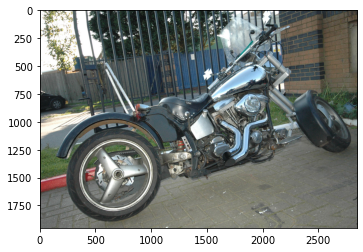

Input image shape:  (1, 224, 224, 3)
Predicted:  [1.0517386e-04 8.7248493e-09 9.4473442e-05 9.9979800e-01 2.1956455e-06
 3.4041800e-08]
It's a motorcycle.
============Processing Image bicycle.jpg============


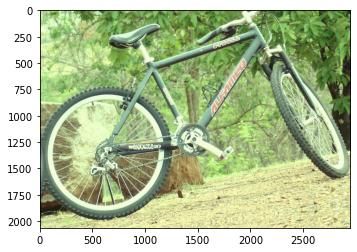

Input image shape:  (1, 224, 224, 3)
Predicted:  [9.9997377e-01 4.7940804e-14 3.1278166e-08 2.6221456e-05 8.8006463e-13
 6.5090077e-14]
It's a bicycle.
============Processing Image truck.jpg============


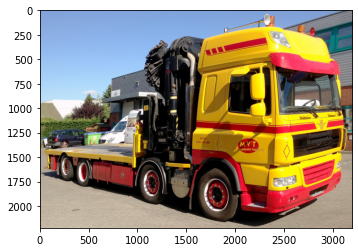

Input image shape:  (1, 224, 224, 3)
Predicted:  [2.6593314e-11 5.5823948e-02 4.5338305e-04 2.1373567e-09 8.0647641e-01
 1.3724619e-01]
It's a truck.
============Processing Image van.jpg============


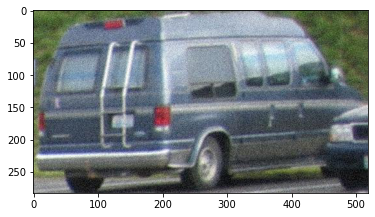

Input image shape:  (1, 224, 224, 3)
Predicted:  [1.3354110e-05 4.8173866e-01 1.8386997e-02 8.8835513e-05 6.0286568e-03
 4.9374348e-01]
It's a van.
============Processing Image car.jpg============


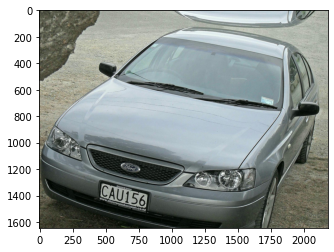

Input image shape:  (1, 224, 224, 3)
Predicted:  [1.1905381e-07 2.7266156e-03 9.1543055e-01 2.2710217e-05 4.1578386e-02
 4.0241562e-02]
It's a car.
============Processing Image bus.jpg============


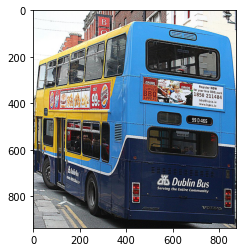

Input image shape:  (1, 224, 224, 3)
Predicted:  [9.7995525e-18 9.9999726e-01 4.9473026e-10 5.9605171e-15 5.2631401e-07
 2.2691222e-06]
It's a bus.


In [ ]:
# test the model on all the images in the test folder
evaluate_all_img(test_path, model)

### Observation:
- All sample images were correctly classified.
- After the first training epoch, the validation accuracy does not improve a lot.
- Further training epochs tend to result in slightly higher training accuracy. 
- Overfitting occurs.

Next step:
- Try to finetune the model by training some convolutional layers.

## Finetune the model 
- Set everything from Block 3 as trainable to train the higher level features that are specific to our classification problem

In [ ]:
model.trainable = True

set_trainable = False
for layer in model.layers:
  if layer.name == 'block3_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
# check status of each layer
for layer in model.layers:
  print(layer.name, "Trainable: ", layer.trainable)

input_1 Trainable:  False
block1_conv1 Trainable:  False
block1_conv2 Trainable:  False
block1_pool Trainable:  False
block2_conv1 Trainable:  False
block2_conv2 Trainable:  False
block2_pool Trainable:  False
block3_conv1 Trainable:  True
block3_conv2 Trainable:  True
block3_conv3 Trainable:  True
block3_pool Trainable:  True
block4_conv1 Trainable:  True
block4_conv2 Trainable:  True
block4_conv3 Trainable:  True
block4_pool Trainable:  True
block5_conv1 Trainable:  True
block5_conv2 Trainable:  True
block5_conv3 Trainable:  True
block5_pool Trainable:  True
global_average_pooling2d Trainable:  True
dense Trainable:  True
dense_1 Trainable:  True


In [ ]:
epochs = 10

## train the model with validation
history = model.fit(train_dataset,
                    steps_per_epoch = train_steps,
                    epochs = epochs,
                    validation_data = valid_dataset,
                    validation_steps=val_steps,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/10
468/468 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9251
Epoch 00001: val_accuracy improved from 0.84976 to 0.86779, saving model to ./checkpoints/model_best_weights.hdf5
468/468 [==============================] - 302s 644ms/step - loss: 0.2144 - accuracy: 0.9251 - val_loss: 0.4341 - val_accuracy: 0.8678
Epoch 2/10
468/468 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9348
Epoch 00002: val_accuracy did not improve from 0.86779
468/468 [==============================] - 302s 646ms/step - loss: 0.1813 - accuracy: 0.9348 - val_loss: 0.4706 - val_accuracy: 0.8522
Epoch 3/10
468/468 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9388
Epoch 00003: val_accuracy did not improve from 0.86779
468/468 [==============================] - 367s 783ms/step - loss: 0.1686 - accuracy: 0.9388 - val_loss: 0.4891 - val_accuracy: 0.8654


In [ ]:
# save model
save_path = r"/drive/My Drive/Vehicle_Type_Classification/my_model.h5"
model.save(save_path)